## Reglas

1. Cualquier celda con un conejo con 0 vecinos con pasto muere, debido a falta de comida.
2. Cualquier celda con un conejo con uno o más vecinos con pasto sobrevive para la siguiente generación.
3. Cualquier celda vacía con 2 vecinos con conejo y un vecino con pasto se convierte en una celda con conejo, debido a la reproducción.
4. Cualquier celda de pasto con 2 vecinos con conejo se convierte en una celda conejo, debido a la reproducción.

In [8]:
!python -m pip install mesa


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import mesa
mesa.__version__

'2.1.2'

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [10]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [11]:
class GameLifeAgent(Agent):
    """
    Representa a un agente o una celda con estado con un conejo (2), con pasto (1) o vacio (0)
    """
    def __init__(self, unique_id, model, bunny=False):
        """
        Crea un agente con estado inicial aleatorio de 0, 1 ó 2, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        if not bunny:
            self.curr_state = np.random.choice([0,1])
        else:
            self.curr_state = np.random.choice([0,1,2])
        self.next_state = None

    def step(self):
        """
        Este método es el que calcula si la celda vivirá o morirá dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)
        
        # 1. Cualquier celda con un conejo con 0 vecinos con pasto muere, debido a falta de comida.
        # 2. Cualquier celda con un conejo con uno o más vecinos con pasto sobrevive para la siguiente generación.
        # 3. Cualquier celda vacía con 2 vecinos con conejo y un vecino con pasto se convierte en una celda viva, debido a la reproducción.

        bunny_neighbours = 0
        grass_neighbours = 0

        # Contar conejos y pasto en vecinos
        for neighbor in neighbours:
            x1,y1 = self.pos
            x2,y2 = neighbor.pos
            
            # Solucionar problema de extension en esquinas del grid
            if (abs(x1 - x2) > 1) or (abs(y1 - y2) > 1):
                continue
            
            if neighbor.curr_state == 2:
                bunny_neighbours = bunny_neighbours + 1
            elif neighbor.curr_state == 1:
                grass_neighbours = grass_neighbours + 1

        self.next_state = self.curr_state

        # 3. Cualquier celda con 2 conejos como vecinos y un vecino con pasto se convierte en una celda con conejo, debido a la reproducción.
        if bunny_neighbours >= 2 and (grass_neighbours >= 1 or self.curr_state == 1):
            self.next_state = 2
        # 1. Cualquier celda con un conejo con 0 vecinos con pasto muere, debido a falta de comida.
        elif self.curr_state == 2 and grass_neighbours == 0:
            self.next_state = 0
        # 2. Cualquier celda con un conejo con uno o más vecinos con pasto sobrevive para la siguiente generación.
        elif self.curr_state == 2 and grass_neighbours >= 1:
            self.next_state = 2

    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.curr_state = self.next_state

class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        # se importa arriba: import random
        # celdas = model.grid.coord_iter()
        # celdas_con_arboles = random.sample(celdas, k=25)
        # posiciones_arboles = [pos for _, pos in celdas_con_arboles]

        for (content, pos) in self.grid.coord_iter():
            # a = GameLifeAgent(pos, self, bunny=True)
            x,y = pos
            if x <= 10 and y <= 10:
                a = GameLifeAgent(pos, self, bunny=True)
            else:
                a = GameLifeAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Bunny": self.get_bunnies}
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.curr_state

        return grid

    def get_bunnies(self):
        total_bunny_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, GameLifeAgent):
                if agent.curr_state == 2:
                    total_bunny_agents += 1

        return total_bunny_agents

# Ejecución del modelo
A continuación corremos el modelo

In [12]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 160

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:06.737816


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [13]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [14]:
all_grids

,Grid,Bunny
0,"[[1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0,...",39
1,"[[1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0,...",97
2,"[[2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0,...",70
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",56
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",49
...,...,...
155,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",67
156,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",62
157,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",60
158,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",57


In [15]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
colors.append(np.array([0, 0, 0, 1]))
colors.append(np.array([22 / 255, 163 / 255, 74 / 255, 1]))
colors.append(np.array([1, 1, 1, 1]))
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=2)

cells_alive = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_alive.append(all_grids['Bunny'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [16]:
anim

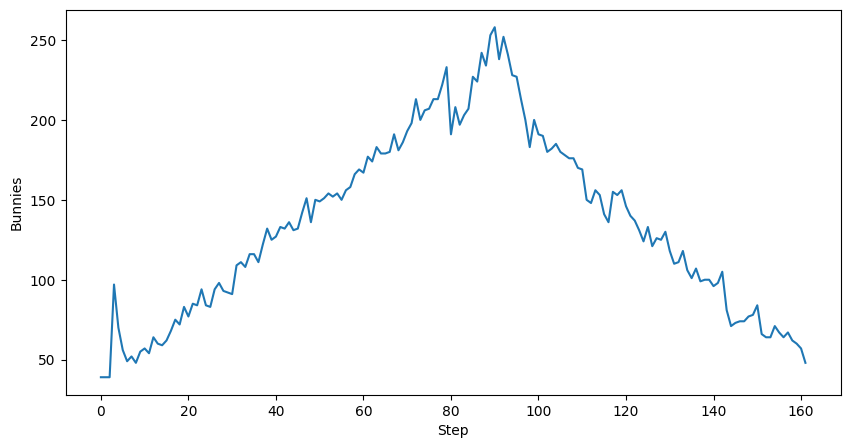

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Bunnies")

plt.plot(cells_alive)
plt.show()

# Batch simulation

In [18]:
NUM_REPS = 100
GRID_SIZE = 100
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['bunny'].append(all_grids['Bunny'].to_numpy())


KeyError: 'bunny'

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Bunnies")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['Bunny'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['Bunny']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['Bunny']), axis=1), color='Red', linestyle='dashed')

plt.show()